In [1]:
# === Basic libraries ===
import numpy as np
import pandas as pd
import time

# === Molecular descriptor calculation ===
from rdkit import Chem
from mordred import Calculator, descriptors

# === Data preprocessing and visuals ===
from sklearn import preprocessing as pp
import seaborn as sns
from sklearn.decomposition import PCA

# === Model and metrics ===
from sklearn import svm
from sklearn import metrics as met
from sklearn.model_selection import cross_val_predict

In [2]:
# === Read in files with X,Y ===
RS_XY = pd.read_csv('Documents/rsxy_v1.csv')
clist = list(RS_XY['SMILES'])
y = np.array(RS_XY['Sens'])
y = np.reshape(y,(-1,1))
X = np.zeros(shape=(len(clist),1826))

# === Calculate descriptors ===
calc = Calculator(descriptors)
for i in range(len(clist)):
    mol = Chem.MolFromSmiles(clist[i])
    X[i,:] = calc(mol)
sh1 = np.shape(X)
print(f'Shape | raw: {sh1}')

# === Filter data and scale ===
X = X[:,~np.any(np.isnan(X), axis=0)]
X = X[:, np.var(X, axis=0) != 0]
scaler = pp.MinMaxScaler().fit(X)
Xs = scaler.transform(X)
sh2 = np.shape(Xs)
print(f'Shape | filtered/scaled: {sh2}')

[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors
[19:54:53] WARNING: not removing hydrogen atom without neighbors


Shape | raw: (158, 1826)
Shape | filtered/scaled: (158, 656)


<Axes: >

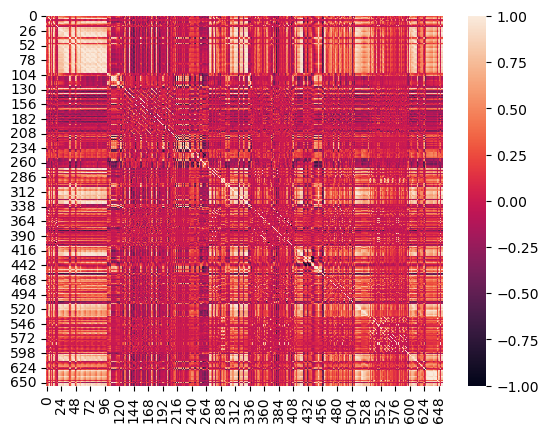

In [3]:
# === Heatmap of feature correlation ===
Xs_pd = pd.DataFrame(Xs)
sns.heatmap(Xs_pd.corr())

<Axes: >

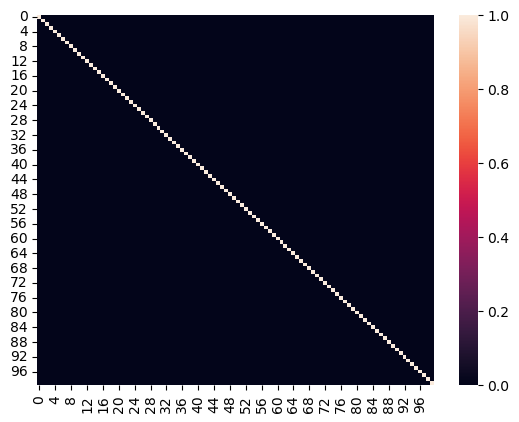

In [27]:
# === Conduct PCA and display updated heatmap ===
pca = PCA(n_components=100,random_state=np.random.seed(0))
pca.fit(Xs_pd)
Xr = pca.transform(Xs_pd)
Xr_pd = pd.DataFrame(Xr)
sns.heatmap(Xr_pd.corr())

In [29]:
# === Support Vector Machines ===
y = y.ravel()
nseed = 100

acc_tst = np.zeros(nseed)
f1s_tst = np.zeros(nseed)
roc_tst = np.zeros(nseed)

t_sta = time.perf_counter()
for i in range(nseed):
    model = svm.SVC(kernel='rbf',C=1,random_state=np.random.seed(0))
    pred = cross_val_predict(model, X, y)
    
    acc_tst[i] = met.accuracy_score(y,pred)
    f1s_tst[i] = met.f1_score(y,pred)
    roc_tst[i] = met.roc_auc_score(y,pred)

t_end = time.perf_counter()
t_ela = t_end-t_sta

m_acc_tst = np.mean(acc_tst)
m_f1s_tst = np.mean(f1s_tst)
m_roc_tst = np.mean(roc_tst)

print(f'Testing Accuracy: {m_acc_tst}')
print(f'Testing F1 Score: {m_f1s_tst}')
print(f'Testing POC AUC: {m_roc_tst}')

print(f'Elapsed Time: {t_ela}')

Testing Accuracy: 0.7025316455696203
Testing F1 Score: 0.2539682539682539
Testing POC AUC: 0.5727272727272725
Elapsed Time: 1.8820863000582904


In [19]:
# === Results Log | Linear ===
#
# Data   | Test                  | Time (s)
#        | acc   | f1s   | roc   |
# -------------------------------
# Raw    | NA    | NA    | NA    | NA
# F/S    | 0.823 | 0.720 | 0.784 | 1
# PCA100 | 0.823 | 0.720 | 0.784 | 1
# PCA50  | 0.810 | 0.681 | 0.757 | 1
# PCA25  | 0.842 | 0.747 | 0.802 | 1

# === Results Log | Poly ===
#
# Data   | Test                  | Time (s)
#        | acc   | f1s   | roc   |
# -------------------------------
# Raw    | 0.696 | 0.226 | 0.564 | 1
# F/S    | 0.816 | 0.667 | 0.749 | 2
# PCA100 | 0.753 | 0.466 | 0.650 | 1
# PCA50  | 0.753 | 0.466 | 0.650 | 1
# PCA25  | 0.741 | 0.453 | 0.640 | 1

# === Results Log | RBF ===
#
# Data   | Test                  | Time (s)
#        | acc   | f1s   | roc   |
# -------------------------------
# Raw    | 0.703 | 0.254 | 0.573 | 2
# F/S    | 0.753 | 0.506 | 0.662 | 2
# PCA100 | 0.810 | 0.659 | 0.744 | 1
# PCA50  | 0.823 | 0.689 | 0.762 | 1
# PCA25  | 0.810 | 0.659 | 0.744 | 1

# === Results Log | Sigmoid ===
#
# Data   | Test                  | Time (s)
#        | acc   | f1s   | roc   |
# -------------------------------
# Raw    | 0.703 | 0.254 | 0.573 | 2
# F/S    | 0.652 | 0.000 | 0.500 | 2
# PCA100 | 0.728 | 0.527 | 0.660 | 1
# PCA50  | 0.703 | 0.495 | 0.636 | 1
# PCA25  | 0.690 | 0.462 | 0.618 | 1
